In [101]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Análisis de salida de CAE mediante clustering

En este notebook se analiza en profundidad los resultados de las variables latentes obtenidas mediante el Autoencoder Convolucional. Para dar validez a estas variables se utlizarán como entrada a un algoritmo de clustering (KMeans), analizando cada grupo creado en base a su morfología y su porcentaje de muestras de _slides_ sanas y tumorales.

__Librerías__

In [102]:
import yaml
import os
from tqdm import tqdm_notebook

In [51]:
import pandas as pd
import numpy as np

In [52]:
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.patches import Patch

In [53]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [96]:
from utils import plot_paired_imgs
from utils import read_images
from utils import imscatter

from model.cae import CAE

In [55]:
from keras.preprocessing.image import ImageDataGenerator

__Configuración__

In [97]:
with open('conf/user_conf.yaml', 'r') as f:
    conf = yaml.load(f)

In [106]:
patches_path = os.path.join(conf['data_path'], 'slides', 'patches')
image_size = conf['wsi']['patch_size']

## Preparación datos

Se analizan conjuntamente los datos de _train_ y _test_ y que se obvervó que no había ovefitting y que por tanto las variables generadas en ambos conjuntos serán similares.

In [105]:
train_df = pd.read_csv(os.path.join(conf['data_path'], 'train.csv'), sep='|')
test_df = pd.read_csv(os.path.join(conf['data_path'], 'test.csv'), sep='|')

data_df = pd.concat([train_df, test_df])

In [107]:
data_df.head(3)

filename                 slide_id       case_id  \
0    TCGA-FB-A4P5-01A-01-TSA_14_71.png  TCGA-FB-A4P5-01A-01-TSA  TCGA-FB-A4P5   
1  TCGA-FZ-5923-01A-01-TS1_052_030.png  TCGA-FZ-5923-01A-01-TS1  TCGA-FZ-5923   
2   TCGA-IB-A5ST-01A-01-TSA_35_133.png  TCGA-IB-A5ST-01A-01-TSA  TCGA-IB-A5ST   

          sample_id                  disease_type    sample_type  \
0  TCGA-FB-A4P5-01A  Ductal and Lobular Neoplasms  Primary Tumor   
1  TCGA-FZ-5923-01A  Ductal and Lobular Neoplasms  Primary Tumor   
2  TCGA-IB-A5ST-01A  Ductal and Lobular Neoplasms  Primary Tumor   

   percent_normal_cells  percent_stromal_cells  percent_tumor_cells  \
0                  20.0                   50.0                 30.0   
1                   0.0                   30.0                 70.0   
2                   6.0                   73.0                 18.0   

   percent_tumor_nuclei  
0                  40.0  
1                  70.0  
2                  20.0

Creación del lector de imágenes, como en este caso únicamente se va a a realizar la codificación el parámetro _class_mode_ se pone a _None_.

In [61]:
imgen = ImageDataGenerator(rescale=1/255)

data_generator = imgen.flow_from_dataframe(data_df, directory=patches_path, x_col='filename', 
                                            target_size=(image_size, image_size), color_mode='rgb', class_mode=None, shuffle=False)

Found 72265 images.


## Predicciones CAE (codificación)

__Carga CAE__

Se carga uno de los modelos ya entrenados, en este caso se utilzará el modelo 1 que tenía una capa de 256 variables latentes.

In [111]:
model = 'model_1'
cae = CAE(path=os.path.join(conf['data_path'], 'models', model), load=True)

In [112]:
cae.latent_features

256

In [113]:
cae.filters

[8, 16, 32]

__Predicción__

Devuelve un array de dimensiones (72265, 256), es decir un vector de 256 elementos por cada una de las muestras.

In [ ]:
data_enc = cae.encoder.predict_generator(data_generator, 
                                         steps=len(data_generator), 
                                         workers=8, 
                                         verbose=1)

In [116]:
data_enc.shape

(72265, 256)

## PCA (reducción de dimensionalidad)

256 variables es un número considerablemente alto como dimensión de entrada a un KMeans, este algoritmo al depender de distancias está muy afectado por lo que se conoce como la _Maldición de la dimensión_. Por este motivo se realiza primero una reducción a un espacio de 20 variables mediante PCA.

In [76]:
pca = PCA(n_components=30)

In [77]:
data_enc_pca = pca.fit_transform(data_enc)

__Varianza explicada__

Con las 30 primeras componentes de un PCA se explica el 60% de la varianza de los datos.

In [120]:
sum(pca.explained_variance_ratio_)

0.5927822426365933

Aunque se puede obvervar que con las 3 primeras la varianza explicada ya es del 40%.

In [78]:
expl_variance = pd.DataFrame({'feature': range(1, pca.n_components + 1),
                              'explained_var': pca.explained_variance_ratio_,
                              'cumulative_explained_var': np.cumsum(pca.explained_variance_ratio_)})

expl_variance[['feature', 'explained_var', 'cumulative_explained_var']].head(10)

feature  explained_var  cumulative_explained_var
0        1       0.292693                  0.292693
1        2       0.074204                  0.366897
2        3       0.035868                  0.402765
3        4       0.022574                  0.425339
4        5       0.012231                  0.437570
5        6       0.011561                  0.449131
6        7       0.009865                  0.458996
7        8       0.009084                  0.468080
8        9       0.008646                  0.476727
9       10       0.008060                  0.484787

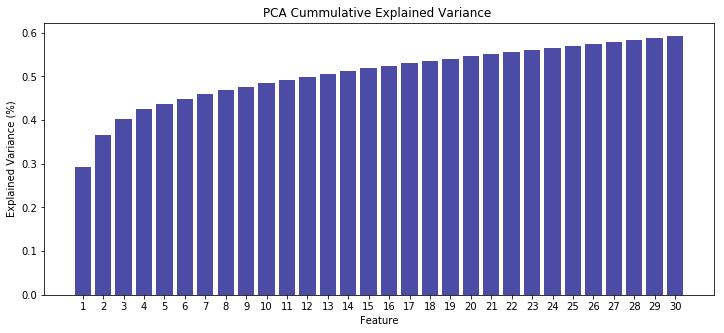

In [68]:
plt.figure(figsize=(12,5))
plt.bar(expl_variance['feature'] - 1, expl_variance['cumulative_explained_var'], align='center', alpha=0.7, color='navy')
plt.xlabel('Feature')
plt.xticks(range(pca.n_components), expl_variance['feature'])
plt.title('PCA Cummulative Explained Variance ')
plt.ylabel('Explained Variance (%)')
pass

## K-Means Clustering

A continuación se realiza un clustering con K-Means sobre las 30 componentes principales del PCA. Para ellos se calcula primero el número óptimo de clusters mediante lo que se conoce como el _metodo del codo_.  Este método consiste en ejecutar el algoritmo sobre un conjunto limitado de Ks y calcular la incercia de cada uno.

La inercia es igual a la suma de las distancias cuadráticas de cada punto al centroide de su cluster, por tanto este valor siempre va a decrecer según aumenta K. Para elegir la K óptima se busca el punto en el que la cambia la pendiente de la curva Inercia/K, es decir, donde la disminución de la incercia empieza a ser menos pronunciada.

__Selección de K (método del codo)__

In [ ]:
Ks = list(range(3,20))
inertias = []

for k in tqdm_notebook(Ks):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(data_enc_pca)
    
    inertias.append(kmeans.inertia_)

Obvervando el gráfico no hay un codo muy claro, estaría entre 6 y 8. Puesto que en este caso una mayor separación puede ayudar a diferenciar mejor entre tipos de imágenes elige un K=8.

Text(0.5, 1.0, 'Elbow method for selecting optimal K')

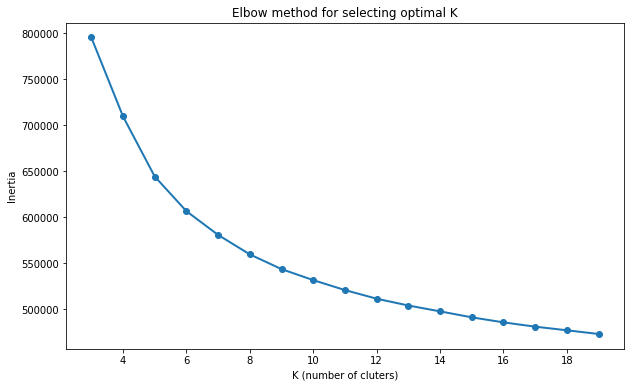

In [70]:
plt.figure(figsize=(10,6))

plt.plot(Ks, inertias, lw=2, marker='o')
plt.xlabel('K (number of cluters)')
plt.ylabel('Inertia')
plt.title('Elbow method for selecting optimal K')

__Reentrenamiento con K óptima (K = 8)__

In [122]:
K = 8
kmeans = KMeans(n_clusters=K)

In [123]:
data_cluster = kmeans.fit_predict(data_enc_pca)

In [124]:
data_df['cluster'] = data_cluster

## Resultados

__Distribución de los clusters__

El segmento 2 tienen un número muy bajo de muestras con respecto a los demás, esto quiere decir que tiene unas imágenes muy diferenciadas.

In [125]:
cluster_counts = data_df.groupby(['cluster']).size().reset_index().rename(columns={0: 'total'})
cluster_counts

cluster  total
0        0   6660
1        1  12804
2        2    195
3        3  13597
4        4   5236
5        5  15629
6        6  16031
7        7   2113

__Ejemplos de cada cluster__

A continuación se dibujan unas pocas muestras de los _patches_ en cada cluster, se aprecia que las imágenes se han agrupado por morfología y color con bastante precisión. Destaca en especial el grupo 2, que contiene imágenes practicamente negras en su totalidad y hace pensar que son errores en la lectura.

Esta representación podría ser etiquetada con ayuda de un médico especializado para poder hacer un análisis más exhaustivo.

 Cluster 0


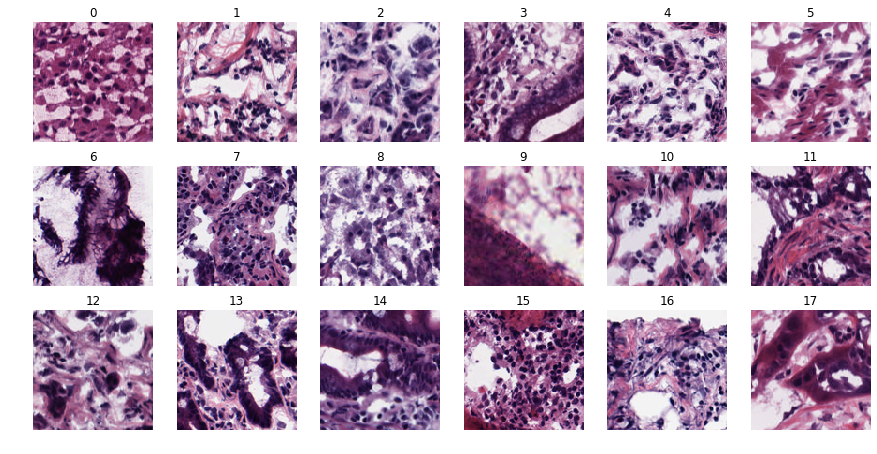

 Cluster 1


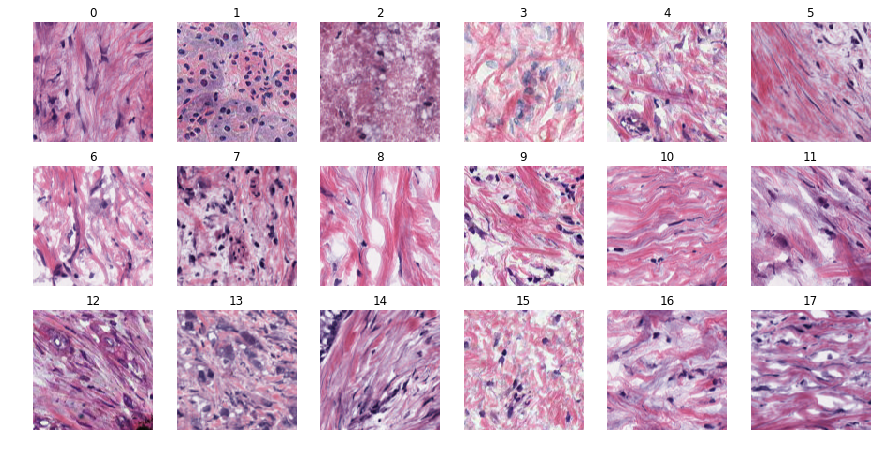

 Cluster 2


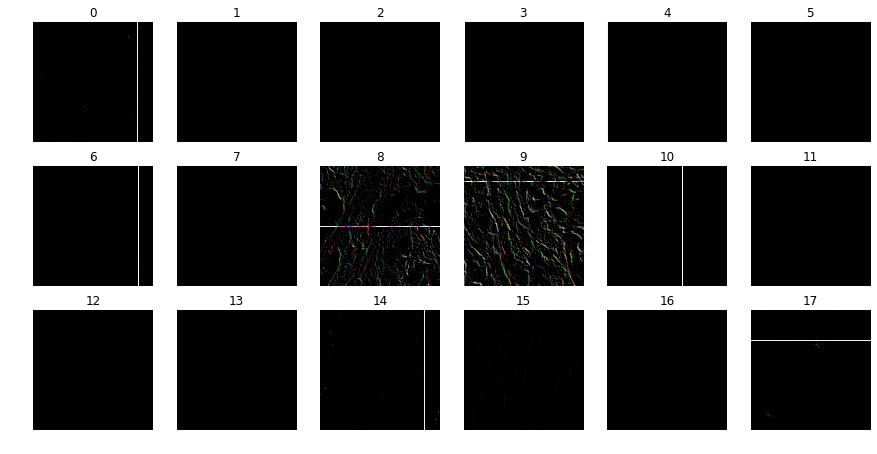

 Cluster 3


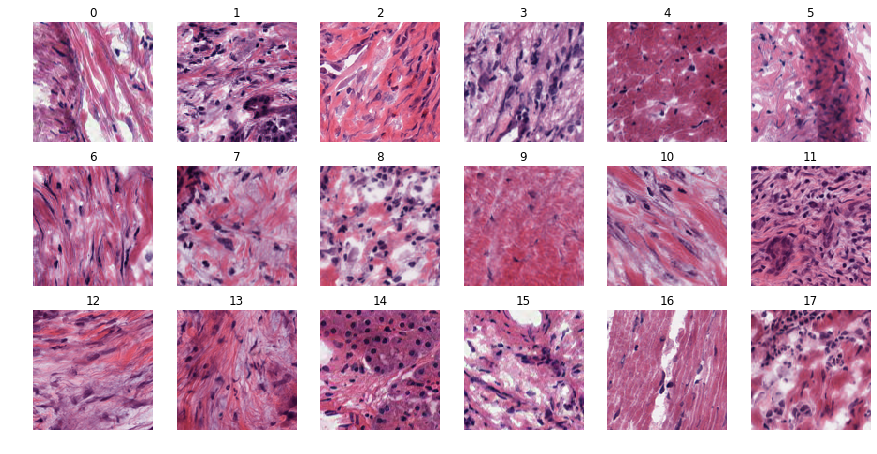

 Cluster 4


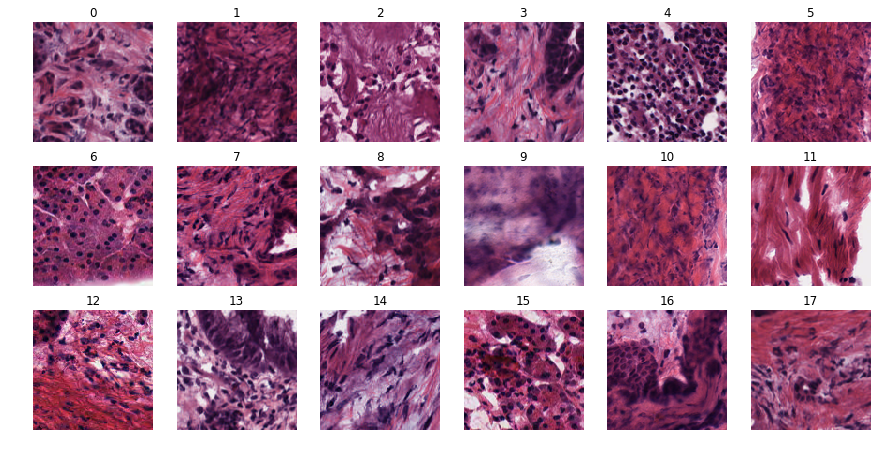

 Cluster 5


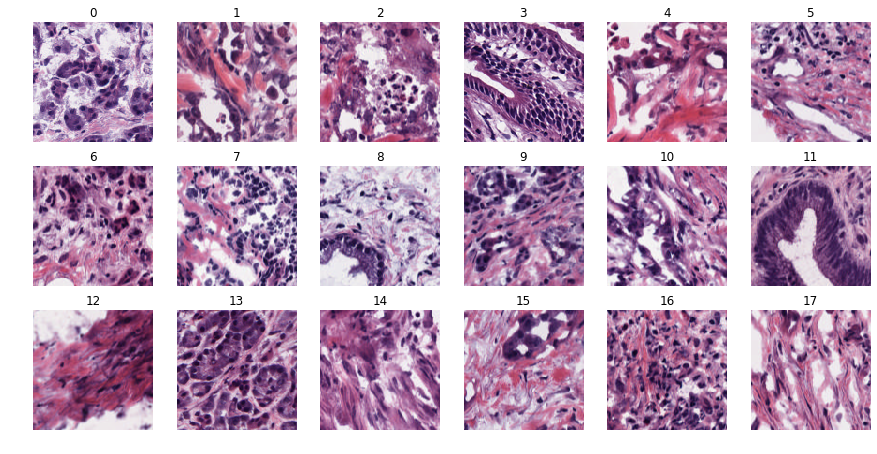

 Cluster 6


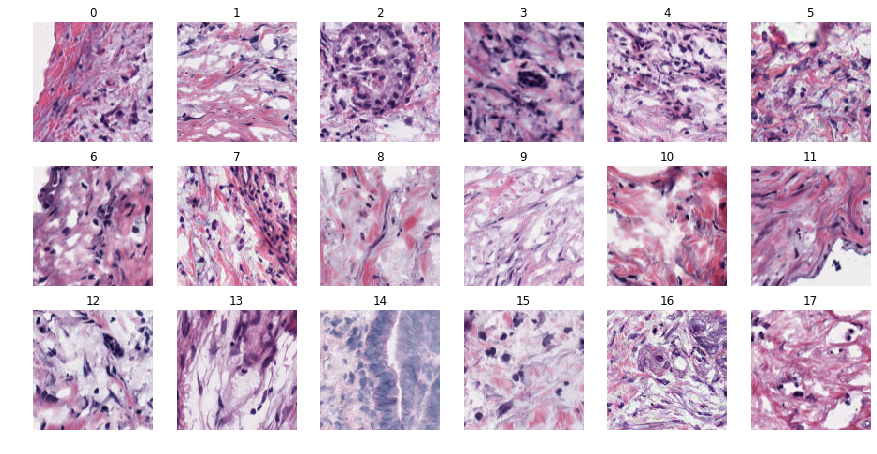

 Cluster 7


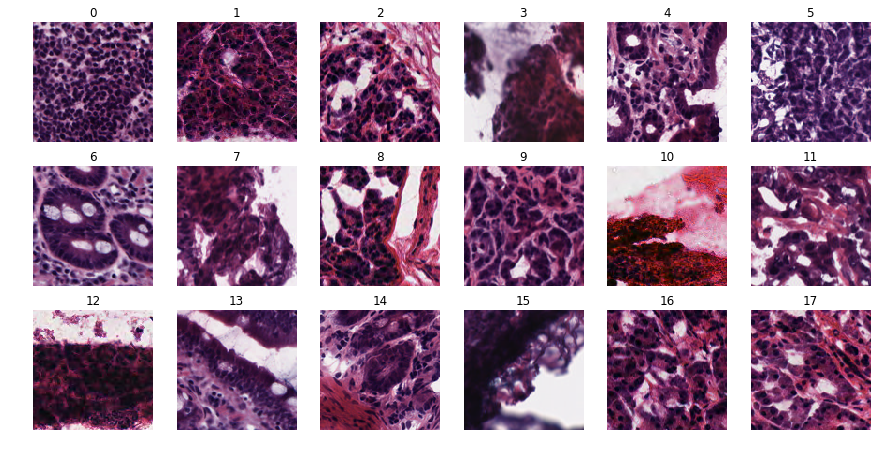

In [126]:
for cluster in range(K):
    
    print('\033[1m Cluster {}'.format(cluster))
    
    sample_data = data_df[data_df['cluster'] == cluster].sample(20)
    sample_imgs = read_images(sample_data['filename'], patches_path)
    
    plot_sample_imgs(sample_imgs, n_rows=3, n_cols=6, size=2.5, color=True, shuffle=False)
    plt.show()

__Tipo de _slide_ por cluster__

Se analizan el ratio de tipos de _slides_ en cada uno de los segmentos. Hay que recordar de nuevo que los _patches_ etiquetados como _Primary Tumor_ pueden ser patches sanos, pero no al revés.

In [150]:
cluster_types = data_df.groupby(['cluster', 'sample_type']).size().unstack().fillna(0)
total = cluster_types.sum(axis=1)
cluster_types['Primary Tumor']  = round(100 * cluster_types['Primary Tumor'] / total, 2)
cluster_types['Solid Tissue Normal']  = round(100 * cluster_types['Solid Tissue Normal'] / total, 2)
cluster_types

sample_type  Primary Tumor  Solid Tissue Normal
cluster                                        
0                    73.80                26.20
1                    97.61                 2.39
2                   100.00                 0.00
3                    92.53                 7.47
4                    62.68                37.32
5                    95.03                 4.97
6                    98.98                 1.02
7                    36.58                63.42

Estas distribuciones pueden orientar a identificar qué _patches_ son realmente tumorales y cuales sanos, aquellos que pertenezcan a grupos con porcentajes altos de muestras sanas como los grupos 4 y 7 podrían ser idenficados como sanos. Los resultados aún así no son concluyentes y requieren un análisis en mayor profundidad, por ejemplo se debería analizar en cuántos clúster caen los _patches_ de cada slide.

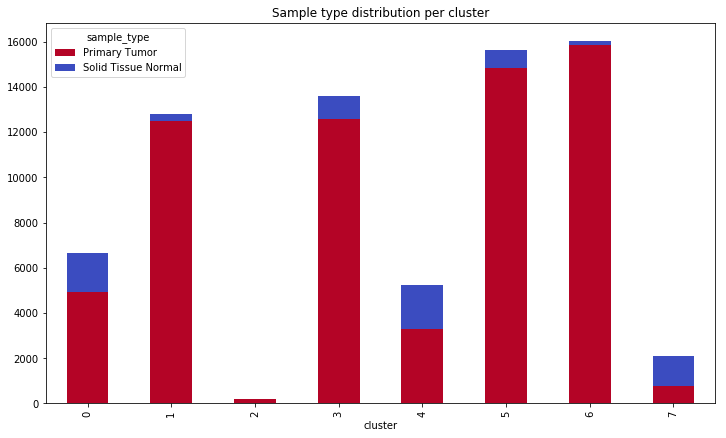

In [127]:
data_df.groupby(['cluster', 'sample_type']).size().unstack().plot(kind='bar', stacked=True, figsize=(12,7), cmap='coolwarm_r')
plt.title('Sample type distribution per cluster')
pass

__Porcentaje medio de tipos de células por cluster__

Un análisis similar al anterior se puede hacer calculando el porcentaje medio de los tipos de células de las _slides_ de cada segmento. Se esperaría ver grupos con porcentajes muy diferenciados. Las conslusiones son parecidas a las anteriores, aunque los porcentajes de células no afectadas son mayores en grupos 4 y 7.

Text(0.5, 1.0, 'Average distribution of cell types in each cluster')

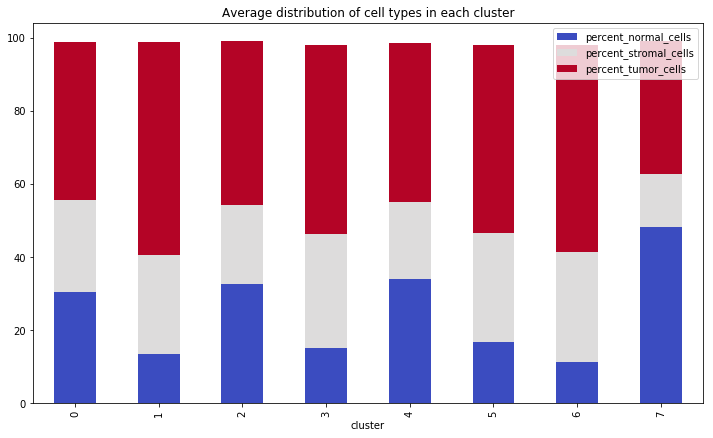

In [154]:
data_df.groupby(['cluster'])[['percent_normal_cells', 'percent_stromal_cells', 'percent_tumor_cells']].mean()\
       .plot(kind='bar', stacked=True, figsize=(12,7), cmap='coolwarm')
plt.title('Average distribution of cell types in each cluster')

__Representación de las muestras de cada cluster en 2D de PCA__

Por último se representan la distribución de un conjunto de muestras en las dos primeras componentes principales del PCA y el clúster al que corresponden. Este dibujo ayuda a ver qué representa cada una de las componentes del PCA. Por ejemplo la primera componente, el eje X, parece identificar los colores oscuros y la segunda componente los espacios blancos; las imágenes con valores más altos en esta componente son opacas.

In [168]:
data_df['pca1'] = data_enc_pca[:,0]
data_df['pca2'] = data_enc_pca[:,1]
data_df['paths'] = data_df['filename'].map(lambda x: os.path.join(patches_path, x))

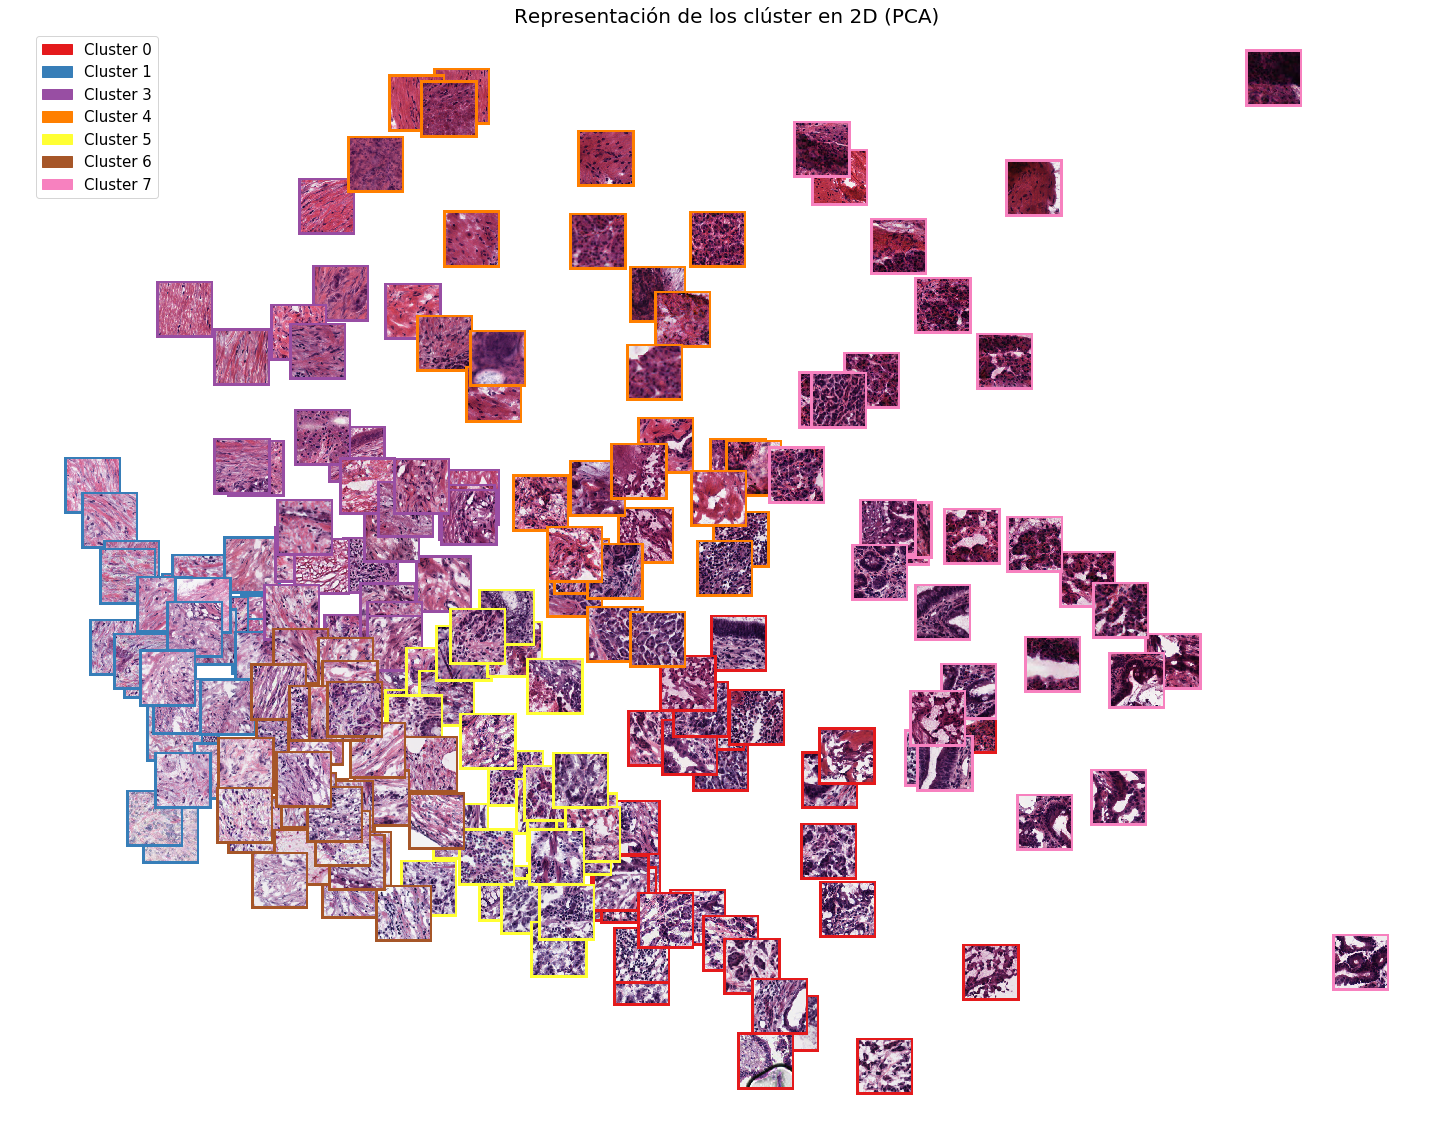

In [177]:
fig, ax = plt.subplots(figsize=(25,20))
cmap = cm.get_cmap('Set1')
n_samples = 30

legend_elements = []

for cluster in range(K):  
    
    if cluster in [2]:
        continue
        
    color = cmap(cluster / K)
    samples = data_df[data_df['cluster'] == cluster].sample(n_samples)
    
    imscatter(samples['pca1'], samples['pca2'], samples['paths'], zoom=0.4, ax=ax, color=color, lw=6)
    legend_elements.append(Patch(facecolor=color, edgecolor=color, label='Cluster {}'.format(cluster)))
    
    
ax.legend(handles=legend_elements, loc='upper left', prop={'size': 15})

plt.axis('off')
plt.title('Representación de los clúster en 2D (PCA)', fontsize=20)
plt.show()